In [20]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import matplotlib.pyplot as plt
import cv2

from mobilenet_v1.mobilenet import MobileNet

from tensorflow.keras.applications.mobilenet import preprocess_input

In [21]:
# the parameters
IMAGE_SIZE = 224
ALPHA=0.75
EPOCHS=20

In [22]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [23]:
# function to define dropout, hidden layers and the number of output
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [24]:
# Using MobileNetv1
base_model=MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), alpha = ALPHA, 
                     depth_multiplier = 1, dropout = 0.001, include_top = False, 
                     weights = "imagenet", classes = 4, backend=keras.backend,
                     layers=keras.layers,models=keras.models,utils=keras.utils)

In [25]:
FC_LAYERS = [100, 50]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=4)

In [26]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('3D_Shapes_Dataset',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', shuffle=True)

Found 1182 images belonging to 4 classes.


In [27]:
finetune_model.summary()
finetune_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history = finetune_model.fit(train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)

finetune_model.save('shape_model.h5')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_pad (ZeroPadding2D)            │ (None, 226, 226, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 24)        │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 24)        │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 24)        │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 24)        │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 48)        │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 48)        │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 114, 114, 48)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 48)          │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 48)          │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 96)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 96)          │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 96)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 96)          │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,915,130 (7.31 MB)

 Trainable params: 82,154 (320.91 KB)

 Non-trainable params: 1,832,976 (6.99 MB)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 485ms/step - accuracy: 0.4335 - loss: 1.4526
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8333 - loss: 0.5719 
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 0.7973 - loss: 0.5179
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7812 - loss: 0.4403 
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 357ms/step - accuracy: 0.9103 - loss: 0.2945
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.9062 - loss: 0.2550 
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 364ms/step - accuracy: 0.9368 - loss: 0.2101
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 1.0000 - loss: 0.1490 
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 365ms/step - accuracy: 0.9678 - loss: 0.1128
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.9688 - loss: 0.0929 
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 0.9668 - loss: 0.1117
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s

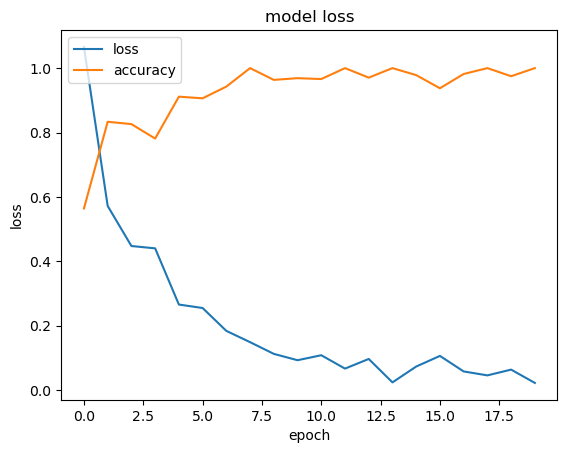

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [29]:
def predict_shape(img_path):
#img_path="3D_Shapes_Dataset/cube/00000963.jpg"
    preprocessed_image = prepare_image(img_path)
    predictions_shape = finetune_model.predict(preprocessed_image) 
    print(predictions_shape)
    labels=['Cube','Cylinder','Spheroid','Sphere']
    img=cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    print("Shape Detected: ", labels[predictions_shape[0].tolist().index(max(predictions_shape[0]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.00994556 0.00398897 0.8134801  0.17258534]]
Shape Detected:  Spheroid


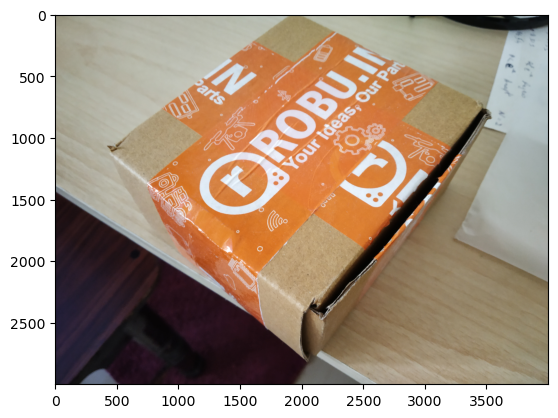

In [30]:
img_path="user_data/box.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[6.1678793e-07 9.4220042e-05 9.9882931e-01 1.0758593e-03]]
Shape Detected:  Spheroid


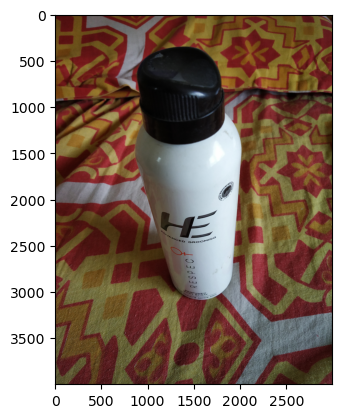

In [31]:
# Real-Life example 2
img_path="user_data/waterbottle.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[7.6779721e-10 4.3308895e-11 2.5794413e-11 1.0000000e+00]]
Shape Detected:  Sphere


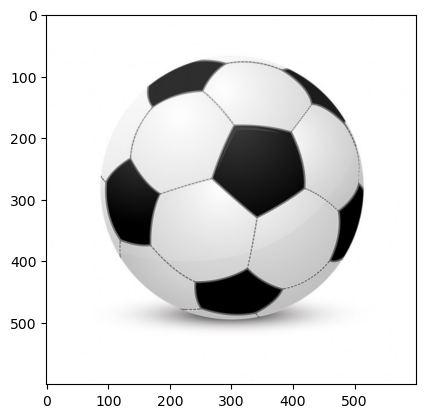

In [32]:
# Real-Life example 3
img_path="user_data/football.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[6.8848012e-06 9.9956900e-01 3.7306166e-04 5.1011808e-05]]
Shape Detected:  Cylinder


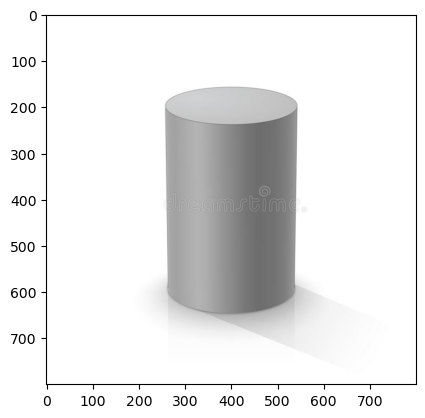

In [33]:
# Real-Life example 4
img_path="user_data/cyn.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[9.8109931e-01 9.7231887e-04 7.5143185e-03 1.0414066e-02]]
Shape Detected:  Cube


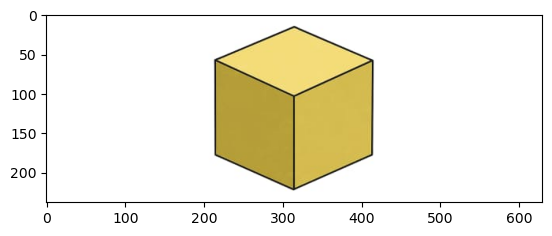

In [34]:
# Real-Life example 4
img_path="user_data/cube-1602256578.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[9.9418688e-01 1.1483682e-03 1.2494954e-04 4.5397948e-03]]
Shape Detected:  Cube


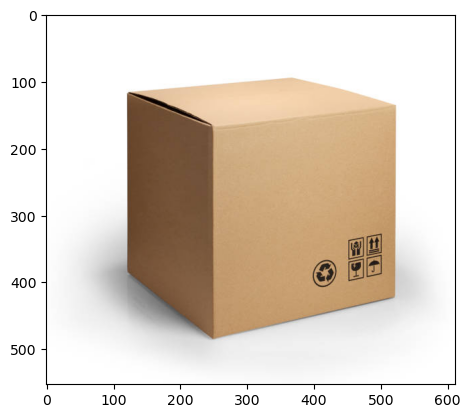

In [35]:
img_path="user_data/box1.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[9.9968481e-01 2.1004409e-05 1.0320015e-06 2.9309519e-04]]
Shape Detected:  Cube


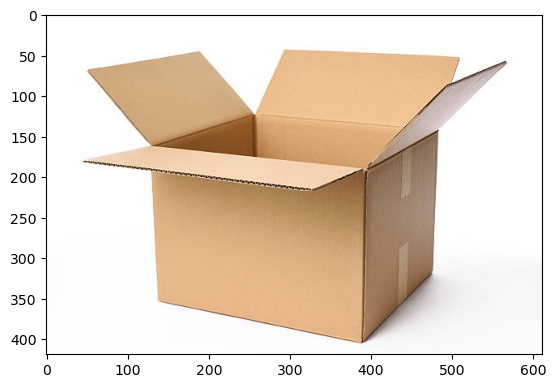

In [36]:
img_path="user_data/box2.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.14453144 0.38410875 0.11042522 0.36093464]]
Shape Detected:  Cylinder


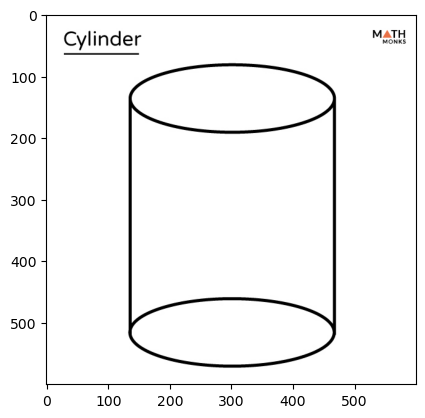

In [40]:
img_path="user_data/cylinder.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.64127916 0.22977085 0.00605405 0.12289596]]
Shape Detected:  Cube


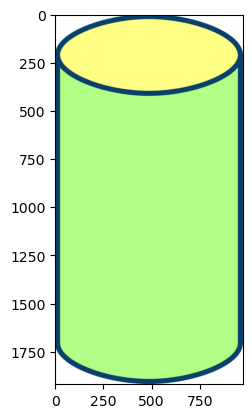

In [49]:
img_path="user_data/cylinder01.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[9.7943505e-04 1.3766990e-02 9.8420250e-01 1.0510124e-03]]
Shape Detected:  Spheroid


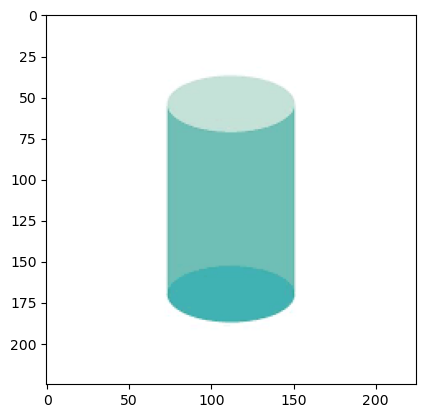

In [50]:
img_path="user_data/cylinder02.jpg"
predict_shape(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[1.8344826e-06 3.0546587e-05 9.9996734e-01 3.6700291e-07]]
Shape Detected:  Spheroid


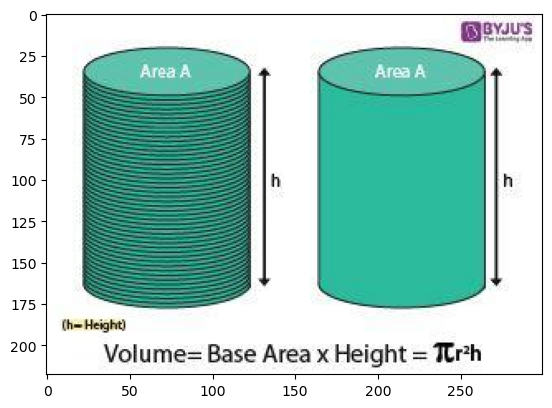

In [51]:
img_path="user_data/cylinder03.jpeg"
predict_shape(img_path)